In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install biopython
!pip install biopython scikit-learn matplotlib
!pip install biopython scikit-learn



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 29.5 MB/s eta 0:00:00


In [3]:
from Bio import SeqIO
import os

folder = '/content/drive/MyDrive/Bioinformatika - jeleni/fastq'
file1 = 'J29_B_CE_IonXpress_005.fastq'
file2 = 'J30_B_CE_IonXpress_006.fastq'

file1_path = os.path.join(folder, file1)
file2_path = os.path.join(folder, file2)

def load_and_filter_fastq(file_path, length_required=296):
    all_reads = list(SeqIO.parse(file_path, "fastq"))
    filtered_reads = [read for read in all_reads if len(read.seq) == length_required]
    return all_reads, filtered_reads

if os.path.exists(file1_path) and os.path.exists(file2_path):
    reads1_all, reads1_296 = load_and_filter_fastq(file1_path)
    reads2_all, reads2_296 = load_and_filter_fastq(file2_path)

    total_reads1 = len(reads1_all)
    total_reard2 = len(reads2_all)
    total_296_1 = len(reads1_296)
    total_296_2 = len(reads2_296)

    print(f"Total reads loaded from J29: {total_reads1}")
    print(f"Reads with exactly 296bp from J29: {total_296_1}")
    print(f"Total reads loaded from J30: {total_reard2}")
    print(f"Reads with exactly 296bp from J30: {total_296_2}")

    filtered1_path = os.path.join(folder, 'file1_296bp.fastq')
    filtered2_path = os.path.join(folder, 'file2_296bp.fastq')

    SeqIO.write(reads1_296, filtered1_path, "fastq")
    SeqIO.write(reads2_296, filtered2_path, "fastq")



Total reads loaded from J29: 5458
Reads with exactly 296bp from J29: 838
Total reads loaded from J30: 3818
Reads with exactly 296bp from J30: 1144


In [4]:
!pip install hdbscan


In [5]:
import hdbscan
from Bio import SeqIO, pairwise2
from Bio.Seq import Seq
from Bio.pairwise2 import format_alignment
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from collections import Counter

# k-mer vectorizer
def get_kmer_vectorized(sequences, k=4):
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(k, k))
    X = vectorizer.fit_transform(sequences)
    return X

#Get representative sequence: closest to cluster center
def get_representative_sequences(X_array, labels, sequences):
    representatives = []
    unique_clusters = set(labels)
    if -1 in unique_clusters:
        unique_clusters.remove(-1)

    for cluster_idx in unique_clusters:
        cluster_indices = np.where(labels == cluster_idx)[0]
        cluster_vectors = X_array[cluster_indices]
        centroid = cluster_vectors.mean(axis=0)
        distances = np.linalg.norm(cluster_vectors - centroid, axis=1)
        closest_idx = cluster_indices[np.argmin(distances)]
        representatives.append(sequences[closest_idx])
    return representatives

# Get most common sequences
def get_most_common_sequences(labels, sequences):
    most_common = []
    unique_clusters = set(labels)
    if -1 in unique_clusters:
        unique_clusters.remove(-1)

    for cluster_idx in unique_clusters:
        cluster_sequences = [sequences[i] for i in range(len(sequences)) if labels[i] == cluster_idx]
        sequence_counts = Counter(cluster_sequences)
        most_common_seq, count = sequence_counts.most_common(1)[0]
        most_common.append((most_common_seq, count))
    return most_common

# Load ground truth sequences
def load_ground_truths(fasta_path):
    return [(record.id, str(record.seq)) for record in SeqIO.parse(fasta_path, "fasta")]

# Align sequence to best matching ground truth
def find_best_alignment(query_seq, ground_truths):
    best_score = -float('inf')
    best_alignment = None
    best_gt_id = None
    for gt_id, gt_seq in ground_truths:
        alignment = pairwise2.align.globalms(query_seq, gt_seq, 2, -1, -5, -0.5, one_alignment_only=True)
        score = alignment[0].score if alignment else -float('inf')
        if score > best_score:
            best_score = score
            best_alignment = alignment[0]
            best_gt_id = gt_id
    return best_alignment, best_gt_id

# Main pipeline
def cluster_sequences_and_compare(fastq_path, label, ground_truth_path, k=4):
    # Load FASTQ reads
    records = list(SeqIO.parse(fastq_path, "fastq"))
    sequences = [str(record.seq) for record in records if record.seq and isinstance(record.seq, (str, Seq))]
    sequences = [seq for seq in sequences if isinstance(seq, str)]

    print(f"[{label}] Number of sequences loaded: {len(sequences)}")

    # Vectorize with k-mers
    X = get_kmer_vectorized(sequences, k)
    X_array = X.toarray()

    # Run HDBSCAN
    clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
    labels = clusterer.fit_predict(X_array)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"[{label}] Found {n_clusters} clusters (excluding noise)")

    # Print cluster sizes
    for clust in sorted(set(labels)):
        count = np.sum(labels == clust)
        name = "Noise" if clust == -1 else f"Cluster {clust}"
        print(f"[{label}] {name}: {count} sequences")

    # Get representatives and most common
    centroid_reps = get_representative_sequences(X_array, labels, sequences)
    mode_reps = get_most_common_sequences(labels, sequences)

    # Load ground truths
    ground_truths = load_ground_truths(ground_truth_path)

    # Align centroid-based representatives
    print(f"\n[{label}] Alignments of REPRESENTATIVES:")
    for i, rep in enumerate(centroid_reps):
        print(f"\nCluster {i}:")
        best_alignment, best_gt_id = find_best_alignment(rep, ground_truths)
        print(f"Best match: {best_gt_id}")
        print(format_alignment(*best_alignment))

    # Align mode-based representatives
    print(f"\n[{label}] Alignments of MOST COMMON sequences:")
    for i, (common_seq, count) in enumerate(mode_reps):
        print(f"\nCluster {i}:")
        print(f"Most common sequence appears {count} times")
        best_alignment, best_gt_id = find_best_alignment(common_seq, ground_truths)
        print(f"Best match: {best_gt_id}")
        print(format_alignment(*best_alignment))



cluster_sequences_and_compare(
    "/content/drive/MyDrive/Bioinformatika - jeleni/fastq/J29_B_CE_IonXpress_005_296bp.fastq",
    "J29",
    "/content/drive/MyDrive/Bioinformatika - jeleni/J29B_expected.fasta"
)

cluster_sequences_and_compare(
    "/content/drive/MyDrive/Bioinformatika - jeleni/fastq/J30_B_CE_IonXpress_006_296bp.fastq",
    "J30",
    "/content/drive/MyDrive/Bioinformatika - jeleni/J30B_expected.fasta"
)

/usr/local/lib/python3.11/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


[J29] Number of sequences loaded: 838


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[J29] Found 2 clusters (excluding noise)
[J29] Noise: 11 sequences
[J29] Cluster 0: 34 sequences
[J29] Cluster 1: 793 sequences

[J29] Alignments of REPRESENTATIVES:

Cluster 0:
Best match: J29B-3_M13F-pUC
GATCCTCTCTCTGCAGCACATTTCCTGCTGTATACTACGAGCGAGTGTCATTTCTCCAACGGGACGCAGCGGGTGGGGTTCCTGGACAGATACTTCTATAACGGAGAAGAGTACGTGCGCTTCGACAGCGACTGGGGCGAGTACCGGGCGGTGACAGAGCTGGGGCGGCCGTCCGCCAAGTACTGGAACAGCCAGAAGGAGTACATGGAGCAGACGCGGGCCGAGGTGGACAGGTACTGCAGACACAACTACGGGGTTCTTGACAGTTTCGCTGTGCAGCGGCGAGGTGACGCGAA
                           |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||                    
---------------------------CTGTATACTACGAGCGAGTGTCATTTCTCCAACGGGACGCAGCGGGTGGGGTTCCTGGACAGATACTTCTATAACGGAGAAGAGTACGTGCGCTTCGACAGCGACTGGGGCGAGTACCGGGCGGTGACAGAGCTGGGGCGGCCGTCCGCCAAGTACTGGAACAGCCAGAAGGA

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[J30] Found 3 clusters (excluding noise)
[J30] Noise: 163 sequences
[J30] Cluster 0: 640 sequences
[J30] Cluster 1: 161 sequences
[J30] Cluster 2: 180 sequences

[J30] Alignments of REPRESENTATIVES:

Cluster 0:
Best match: jelenref02
GATCCTCTCTCTGCAGCACATTTCCTGGAGTATGCTAAGAGCGAGTGTCATTTCTCCAACGGGACGCAGCGGGTGCGGTTCCTGGACAGATACTTCTATAACCGGGAAGAGTACGTGCGCTTCGACAGCGACTGGGGCGAGTTCCGGGCGGTGACCGAGCTGGGGCGGCCGTCCGCCAAGTACTGGAACAGCCAGAAGGATTTCATGGAGCAGAAGCGGGCCGAGGTGGACACGGTGTGCAGACACAACTACGGGGTTATTGAGAGTTTCACTGTGCAGCGGCGAGGTGACGCGAA
                           |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||                    
---------------------------GAGTATGCTAAGAGCGAGTGTCATTTCTCCAACGGGACGCAGCGGGTGCGGTTCCTGGACAGATACTTCTATAACCGGGAAGAGTACGTGCGCTTCGACAGCGACTGGGGCGAGTTCCGGGCGGTGACCGAGCTGGGGCGGCCGT

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


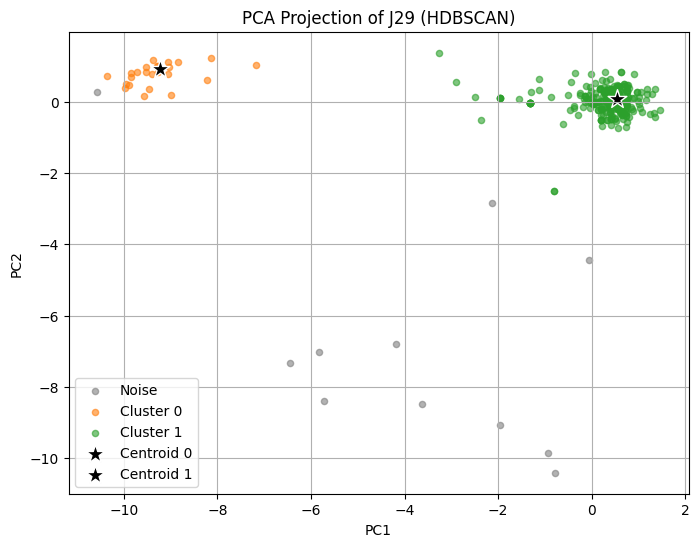

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


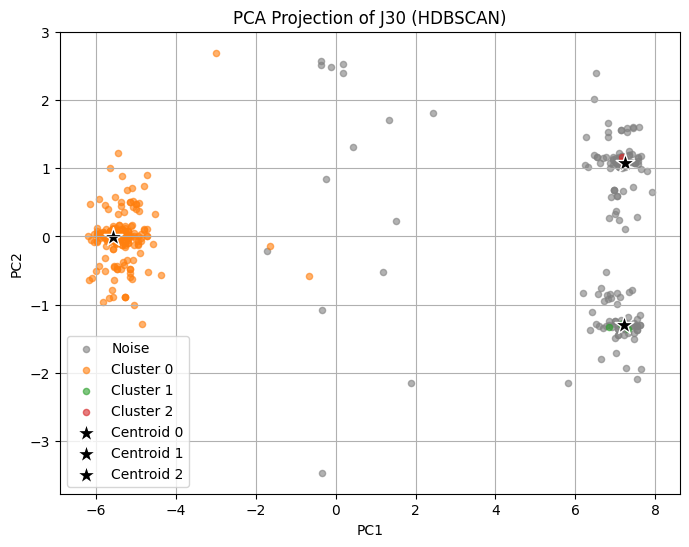

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from Bio import SeqIO
import hdbscan
import numpy as np

def clean_sequence(seq):
    return ''.join(str(seq).strip().upper().replace('\n', '').replace('\r', '').replace(' ', ''))

def get_kmer_vectorized(sequences, k=4):
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(k, k))
    X = vectorizer.fit_transform(sequences)
    return X

def get_representative_indices(X_array, labels):
    reps_idx = []
    unique_clusters = set(labels)
    if -1 in unique_clusters:
        unique_clusters.remove(-1)  # Skip noise

    for cluster_idx in unique_clusters:
        cluster_indices = np.where(labels == cluster_idx)[0]
        cluster_vectors = X_array[cluster_indices]
        centroid = cluster_vectors.mean(axis=0)
        distances = np.linalg.norm(cluster_vectors - centroid, axis=1)
        closest_idx = cluster_indices[np.argmin(distances)]
        reps_idx.append(closest_idx)
    return reps_idx

def cluster_and_visualize_with_pca_and_centroids(file_path, label, k=4, min_cluster_size=10):
    # Load and clean sequences
    records = list(SeqIO.parse(file_path, "fastq"))
    sequences = [clean_sequence(r.seq) for r in records]

    # Vectorize
    X = get_kmer_vectorized(sequences, k)
    X_array = X.toarray()

    # HDBSCAN Clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    labels = clusterer.fit_predict(X_array)

    # Get representative
    rep_indices = get_representative_indices(X_array, labels)

    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_array)

    # Plot
    plt.figure(figsize=(8, 6))
    unique_labels = sorted(set(labels))
    colors = plt.cm.tab10.colors

    for i, lab in enumerate(unique_labels):
        idx = labels == lab
        color = 'gray' if lab == -1 else colors[i % len(colors)]
        label_name = "Noise" if lab == -1 else f"Cluster {lab}"
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                    label=label_name, c=[color], alpha=0.6, s=20)

    # Highlight representative sequences
    for i, rep_idx in enumerate(rep_indices):
        plt.scatter(X_pca[rep_idx, 0], X_pca[rep_idx, 1],
                    c='black', marker='*', s=200, edgecolors='white',
                    label=f'Centroid {i}')

    plt.title(f"PCA Projection of {label} (HDBSCAN)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.show()

cluster_and_visualize_with_pca_and_centroids(
    "/content/drive/MyDrive/Bioinformatika - jeleni/fastq/J29_B_CE_IonXpress_005_296bp.fastq", "J29"
)

cluster_and_visualize_with_pca_and_centroids(
    "/content/drive/MyDrive/Bioinformatika - jeleni/fastq/J30_B_CE_IonXpress_006_296bp.fastq", "J30"
)
